# Datengetriebene Strategieentwicklung für WealthyGrowth
## Eine statistische Analyse globaler Wachstumshebel

### 1. Daten laden

#### 1.1 Bibliotheken installieren

In [2]:
from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

#### 1.2 Daten laden

In [3]:
gdp_df = pd.read_csv('data/gdp_per_capita.csv', skiprows=4)
life_exp_df = pd.read_csv('data/life_expectancy.csv', skiprows=4)
fertility_df = pd.read_csv('data/fertility_rate.csv', skiprows=4)
school_df = pd.read_csv('data/school_enrollment.csv', skiprows=4)
child_mortality_df = pd.read_csv('data/child_mortality.csv', skiprows=4)

# Auszug aus dem ersten Datensatz zur Ansicht
gdp_df.head(2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,27441.529662,28440.051964,30082.127645,31096.205074,22855.93232,27200.061079,30559.533535,33984.790620,NaN,NaN
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,186.121835,186.941781,197.402402,225.440494,208.999748,226.876513,...,1329.807285,1520.212231,1538.901679,1493.817938,1344.10321,1522.393346,1628.318944,1510.742951,1567.635839,NaN


### 2. Daten transformieren
#### 2.1. Umwandeln in das "Long" Format und erste Filterung nach relevanten Jahren (2000-2023)
Im Long Format gibt es für jedes Land für jedes Jahr eine Zeile. Dies ist für die weitere Analyse die bessere Struktur.

In [4]:
# Funktion, um Daten in das "Long" Format umzuwandeln
def transform_to_long(df, value_name):
    df_long = df.melt(
        id_vars=['Country Name', 'Country Code'],
        var_name='Year',
        value_name=value_name
    )
    # Irrelevante Spalten entfernen
    df_long = df_long.drop(columns=['Country Code'])
    df_long['Year'] = pd.to_numeric(df_long['Year'], errors='coerce')
    df_long = df_long.dropna(subset=['Year'])
    df_long['Year'] = df_long['Year'].astype(int)
    
    # Filtern auf den relevanten Zeitraum
    df_long = df_long[(df_long['Year'] >= 2000) & (df_long['Year'] <= 2023)]
    return df_long

# Funktion auf alle DataFrames anwenden
gdp_long = transform_to_long(gdp_df, 'GDP_per_Capita')
life_exp_long = transform_to_long(life_exp_df, 'Life_Expectancy')
fertility_long = transform_to_long(fertility_df, 'Fertility_Rate')
school_long = transform_to_long(school_df, 'School_Enrollment')
child_mortality_long = transform_to_long(child_mortality_df, 'Child_Mortality')

# Auszug aus dem transformierten Datensatz zur Überprüfung der Struktur
life_exp_long.head(3)

,Country Name,Year,Life_Expectancy
11172,Aruba,2000,72.939
11173,Africa Eastern and Southern,2000,52.557342
11174,Afghanistan,2000,55.005


#### 2.2. DataFrames zusammenführen
Hier werden alle Daten zu einem großen Data-Frame zusammengeführt.

In [5]:
# Liste der DataFrames, die zusammengeführt werden sollen
data_frames = [gdp_long, life_exp_long, fertility_long, school_long, child_mortality_long]

# Alle DataFrames zusammenführen über Jahr und Names des Landes
df_merged = reduce(lambda left, right: pd.merge(left, right, on=['Country Name', 'Year'], how='outer'), data_frames)

# Die Namern der Indikator Spalten im Haupt-Dataframe
indicator_cols = ['GDP_per_Capita', 'Life_Expectancy', 'Fertility_Rate', 'School_Enrollment', 'Child_Mortality']

# Ansicht zur Überprüfung der Struktur
df_merged.head(3)

,Country Name,Year,GDP_per_Capita,Life_Expectancy,Fertility_Rate,School_Enrollment,Child_Mortality
0,Afghanistan,2000,174.930991,55.005,7.566,NaN,131.7
1,Afghanistan,2001,138.706822,55.511,7.453,14.04041,127.4
2,Afghanistan,2002,178.954088,56.225,7.32,NaN,123.1


### 3. Daten bereinigen
#### 3.1. Datensätze filtern, die keine Länder sind
Viele Einträge in den Datensätzen der World Bank beziehen sich auf Regionen oder Einkommensgruppen. Für diese Analyse sollen allerdings nur einzelne Länder betrachtet werden.

In [6]:
# Diese Excel-Datei der World-Bank enthält die Informationen, um Länderbezeichnungen von Regionen oder anderen Gruppen zu unterscheiden
classification_df = pd.read_excel('data/class.xlsx', sheet_name='List of economies')

# Daten, die keine Länder sind, haben keine zugewiesene Region, diese werden hier entfernt
countries_with_region = classification_df.dropna(subset=['Region'])

# Das sind die Ländernamen aus der Liste
valid_country_names = countries_with_region['Economy'].tolist()

# Den zusammengeführten DataFrame mit der Liste der validen Ländernamen filtern
df_cleaned = df_merged[df_merged['Country Name'].isin(valid_country_names)].copy()

for col in indicator_cols:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

print(f"Anzahl der Länder VOR Bereinigung: {df_merged['Country Name'].nunique()}")
print(f"Anzahl der entfernten Einträge: {df_merged['Country Name'].nunique() - df_cleaned['Country Name'].nunique()}")
country_sum = df_cleaned['Country Name'].nunique();
print(f"Anzahl der Länder NACH Bereinigung: {country_sum}")

Anzahl der Länder VOR Bereinigung: 266
Anzahl der entfernten Einträge: 55
Anzahl der Länder NACH Bereinigung: 211


#### 3.2 Datensätze filtern,  für die zu wenig Daten zur Verfügung stehen
Länder, welche keine oder zu wenige Daten zur Verfügung stellen, um eine fundierte Analyse durchführen zu können, werden hier entfernt.


In [7]:
# In 25 Prozent der Jahre von 2000 bis 2023 (24 Jahre) müssen Daten vorhanden sein
min_data_points = 24 * 0.25

# Pro Land die verfügbaren Datenpunkte für jeden Indikator zählen
data_counts = df_merged.groupby('Country Name').count()

# Länder identifizieren, die die Bedingung für MINDESTENS EINEN Indikator NICHT erfüllen
countries_to_remove = data_counts[
    (data_counts[indicator_cols] < min_data_points).any(axis=1)
].index

# Erstellen des bereinigten DataFrames
df_cleaned = df_cleaned[~df_cleaned['Country Name'].isin(countries_to_remove)].copy()

# Zeige an, wie viele Länder pro Spalte die Bedingung NICHT erfüllen
print("Anzahl der Länder, die pro Indikator zu wenige Daten haben:")
failing_counts = (data_counts[indicator_cols] < min_data_points).sum()

failing_counts_sum = (data_counts[indicator_cols] < min_data_points).sum().sum()
print(failing_counts)
print(f"Anzahl der Länder VOR Bereinigung: {country_sum}")
print(f"Anzahl der entfernten Länder: {country_sum - df_cleaned['Country Name'].nunique()}")
country_sum = df_cleaned['Country Name'].nunique()
print(f"Anzahl Länder nach der Bereinigung: {country_sum}")

Anzahl der Länder, die pro Indikator zu wenige Daten haben:
GDP_per_Capita        5
Life_Expectancy       1
Fertility_Rate        1
School_Enrollment    36
Child_Mortality      22
dtype: int64
Anzahl der Länder VOR Bereinigung: 211
Anzahl der entfernten Länder: 40
Anzahl Länder nach der Bereinigung: 171


### 4. Fehlende Werte in den Daten ergänzen
#### 4.1. Fehlende Werte interpolieren
Da in einigen Jahren Werte fehlen, müssen diese bestmöglich geschätzt werden. Dazu wird zuerst überprüft wie viele Werte pro Indikator fehlen. Anschließend wird ein lineares Modell erzeugt, welches diese Werte schätzt und die fehlenden Zeilen auffüllt.

In [8]:
# Überprüfen, wie viele Werte interpoliert werden müssen
print("Fehlende Werte vor der Interpolation:")
print(df_cleaned[indicator_cols].isnull().sum())

Fehlende Werte vor der Interpolation:
GDP_per_Capita        32
Life_Expectancy        0
Fertility_Rate         0
School_Enrollment    878
Child_Mortality        0
dtype: int64


In [9]:
# Kopie des bereinigten DataFrames erstellen, auf der dann interpoliert wird
df_interpolated = df_cleaned.copy()

# Interpolation über die Methode LinearRegression() von sklearn
# Loop durch alle Länder und Indikatoren
for country in df_interpolated['Country Name'].unique():
    for col in indicator_cols:
        country_df = df_interpolated[df_interpolated['Country Name'] == country]
        
        if country_df[col].isnull().any():
            train_df = country_df.dropna(subset=[col])
            predict_df = country_df[country_df[col].isnull()]
            
            if len(train_df) >= 2:
                X_train = train_df['Year'].values.reshape(-1, 1)
                y_train = train_df[col].values
                
                model = LinearRegression()
                model.fit(X_train, y_train)
                
                X_predict = predict_df['Year'].values.reshape(-1, 1)
                predictions = model.predict(X_predict)
                
                df_interpolated.loc[predict_df.index, col] = predictions

# Überprüfen, ob alle Werte interpoliert wurden
print("\nFehlende Werte nach der Interpolation:")
print(df_interpolated[indicator_cols].isnull().sum())


Fehlende Werte nach der Interpolation:
GDP_per_Capita       0
Life_Expectancy      0
Fertility_Rate       0
School_Enrollment    0
Child_Mortality      0
dtype: int64


#### 4.2 Visualisierung und Überprüfung der Interpolation
Hier wird visuell überprüft, wie gut die lineare Regression die einzelnen Indikatoren interpoliert. Da nur *GDP_per_Capita* und *School_Enrollment* interpoliert werden müssen, werden die anderen Indikatoren hier nicht visualisiert.

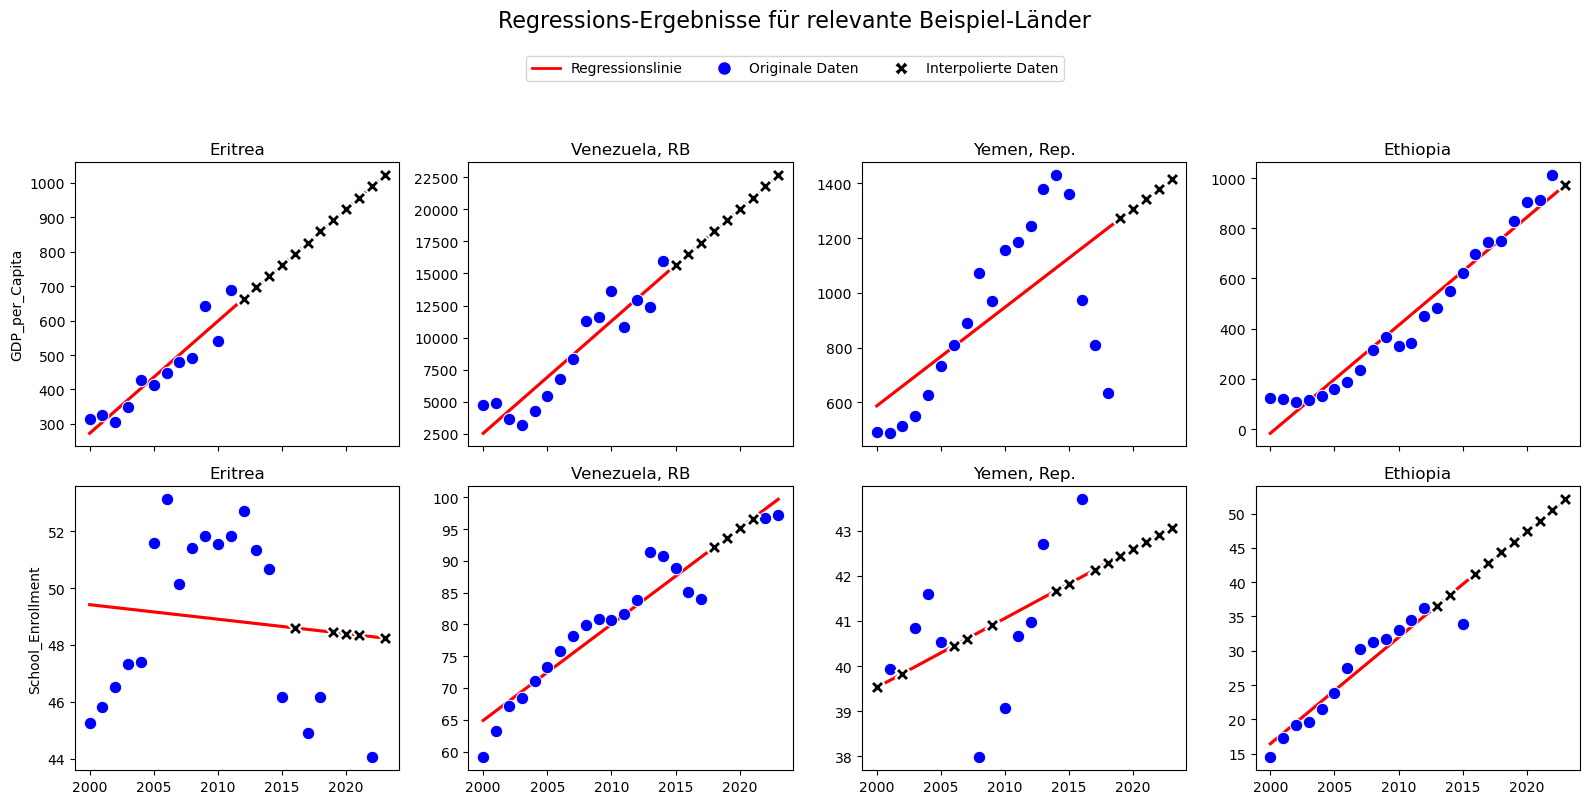

In [10]:
# Relevante Länder zur Visualisierung finden, d.h. Länder, bei denen GDP per Capita und School Enrollment interpoliert wurden
indicators_to_plot = ['GDP_per_Capita', 'School_Enrollment']
missing_both_rows = df_cleaned[
    df_cleaned['GDP_per_Capita'].isnull() & 
    df_cleaned['School_Enrollment'].isnull()
]
countries_missing_both = missing_both_rows['Country Name'].unique()
sample_size = min(4, len(countries_missing_both))
countries_sample_list = pd.Series(countries_missing_both).sample(sample_size).tolist()

# Manuelles Erstellen des Plot-Gitters
fig, axes = plt.subplots(
    nrows=len(indicators_to_plot), 
    ncols=sample_size, 
    figsize=(16, 8),
    sharex=True
)
if len(indicators_to_plot) == 1:
    axes = np.array([axes])


# Loop durch das Gitter mit Anpassungen
for i, indicator in enumerate(indicators_to_plot):
    for j, country in enumerate(countries_sample_list):
        ax = axes[i, j]
        
        original_data = df_cleaned[df_cleaned['Country Name'] == country]
        completed_data = df_interpolated[df_interpolated['Country Name'] == country]
        nan_indices = original_data[original_data[indicator].isnull()].index
        interpolated_points_only = completed_data.loc[nan_indices]

        # 'completed_data', um eine durchgehende Regressionslinie zu gewährleisten
        sns.regplot(
            data=completed_data, x='Year', y=indicator, ax=ax,
            color='red',
            scatter=False,  # Punkte werden später selbst gezeichnet
            ci=None,        # kein Konfidenzintervall
            line_kws={'zorder': 1}
        )
        
        # die originalen Datenpunkte (blaue Punkte) zeichnen
        sns.scatterplot(data=original_data, x='Year', y=indicator, ax=ax, color='blue', s=80, zorder=2)
        
        # die interpolierten Punkte (schwarze Kreuze) zeichnen
        if not interpolated_points_only.empty:
            sns.scatterplot(
                data=interpolated_points_only, x='Year', y=indicator, ax=ax, 
                color='black',
                marker='X',
                s=100,
                zorder=3,
                linewidth=1.5
            )

        ax.set_title(country)
        ax.set_xlabel('')
        ax.set_ylabel('')

# Finale Anpassungen mit aktualisierter Legende
for i, indicator in enumerate(indicators_to_plot):
    axes[i, 0].set_ylabel(indicator)

fig.suptitle('Regressions-Ergebnisse für relevante Beispiel-Länder', y=1.0, size=16)

# Manuelle Legende erstellen
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Regressionslinie'),
    Line2D([0], [0], marker='o', color='w', label='Originale Daten', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='X', color='w', label='Interpolierte Daten', markerfacecolor='black', markersize=10)
]
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3)

plt.tight_layout(rect=[0, 0, 1, 0.9])

plt.savefig(
    'regression.png', 
    dpi=300, # Auflösung in "dots per inch" 
    bbox_inches='tight' # Schneidet überschüssigen weißen Rand ab
)

plt.show()

### 5. Korrelationsanalysen

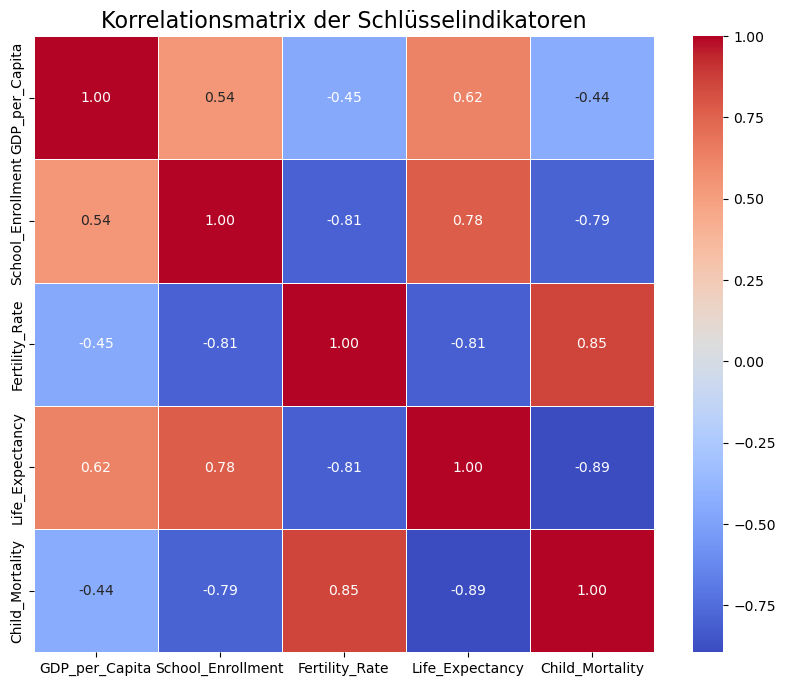

In [11]:
# Relevante Spalten aus dem finalen DataFrame
correlation_df = df_interpolated[['GDP_per_Capita', 'School_Enrollment', 'Fertility_Rate', 'Life_Expectancy', 'Child_Mortality']]

# Berechnen der Korrelationsmatrix, die Standardmethode ist hier der Pearson-Korrelationskoeffizient
corr_matrix = correlation_df.corr()

# Erstellen einer Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True,     # Zeigt die Korrelationswerte in den Zellen an
    cmap='coolwarm',# Farbschema: Blau (negativ) bis Rot (positiv)
    fmt=".2f",      # Formatiert die Zahlen auf zwei Dezimalstellen
    linewidths=.5
)
plt.title('Korrelationsmatrix der Schlüsselindikatoren', fontsize=16)

plt.savefig(
    'corr_matrix.png', 
    dpi=300, # Auflösung in "dots per inch" 
    bbox_inches='tight' # Schneidet überschüssigen weißen Rand ab
)

plt.show()

### 6. Weitere Scatter Plots
Die Korrelationsanalyse zeigt, dass: 
* *Life_Expectancy* (0.62) und *School_Enrollment* (0.54) **insgesamt am stärksten direkt dem *GDP_per_Capita* korrelieren**
* *Life_Expectancy* und *School_Enrollment* **stark positiv** korrelieren (0.78)
* *Fertility_Rate* und *School_Enrollment* **sehr stark negativ** korrelieren (-0.81)
* *Fertility_Rate* und *Child_Mortality* **sehr stark positiv** korrelieren (0.85)
* *Fertility_Rate* und *Life_Expectancy* **sehr stark negativ** korrelieren (-0.81)
* *Life_Expectancy* und *Child_Mortality* **sehr stark negativ** korrelieren (-0.89)

Hier werden weitere Scatter Plots erzeugt, um die Zusammenhänge besser einordnen zu können.

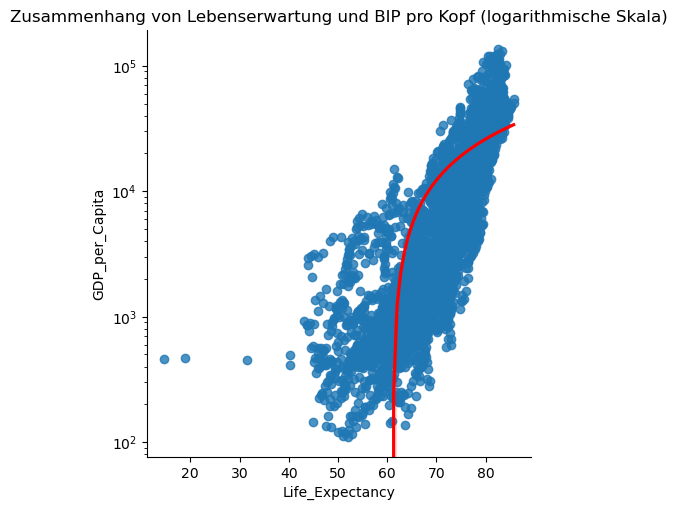

In [12]:
sns.lmplot(data=df_interpolated, x='Life_Expectancy', y='GDP_per_Capita', height=5, line_kws={'color': 'red'}).ax.set_yscale('log')
plt.title('Zusammenhang von Lebenserwartung und BIP pro Kopf (logarithmische Skala)')

plt.savefig(
    'lifeexp_vs_gdp_scatter_plot.png', 
    dpi=300, # Auflösung in "dots per inch" 
    bbox_inches='tight' # Schneidet überschüssigen weißen Rand ab
)

plt.show()

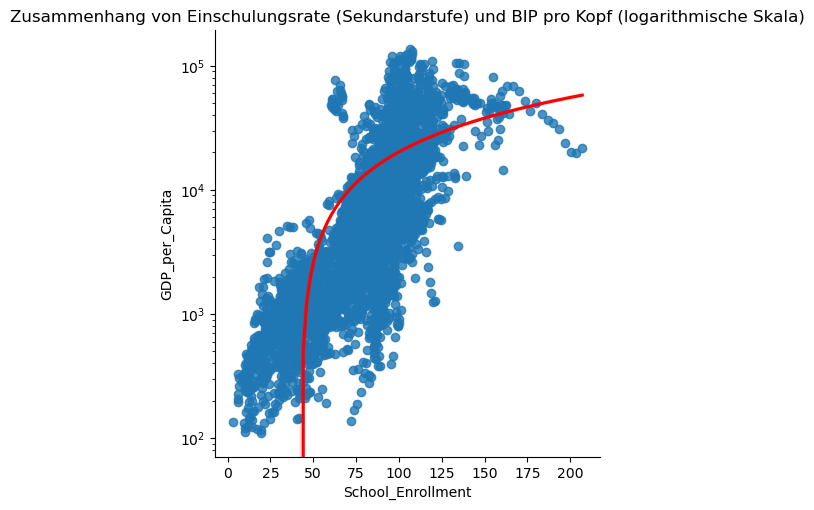

In [13]:
sns.lmplot(data=df_interpolated, x='School_Enrollment', y='GDP_per_Capita', height=5, line_kws={'color': 'red'}).ax.set_yscale('log')
plt.title('Zusammenhang von Einschulungsrate (Sekundarstufe) und BIP pro Kopf (logarithmische Skala)')

plt.savefig(
    'school_vs_gdp_scatter_plot.png', 
    dpi=300, # Auflösung in "dots per inch" 
    bbox_inches='tight' # Schneidet überschüssigen weißen Rand ab
)

plt.show()

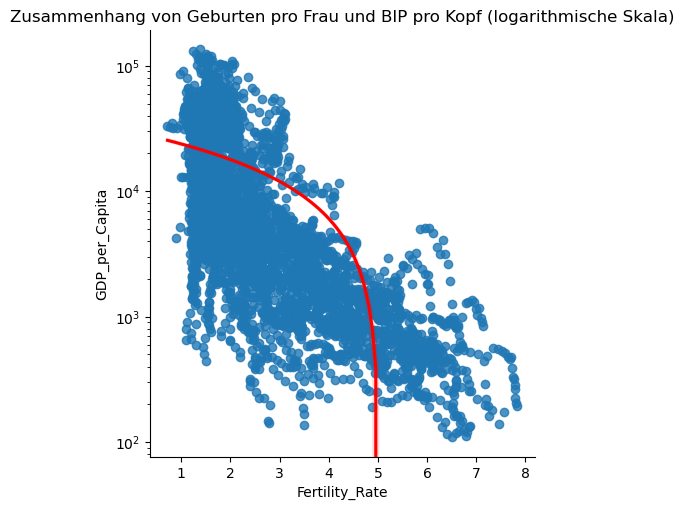

In [14]:
sns.lmplot(data=df_interpolated, x='Fertility_Rate', y='GDP_per_Capita', height=5, line_kws={'color': 'red'}).ax.set_yscale('log')
plt.title('Zusammenhang von Geburten pro Frau und BIP pro Kopf (logarithmische Skala)')

plt.savefig(
    'fertility_vs_gdp_scatter_plot.png', 
    dpi=300, # Auflösung in "dots per inch" 
    bbox_inches='tight' # Schneidet überschüssigen weißen Rand ab
)
plt.show()

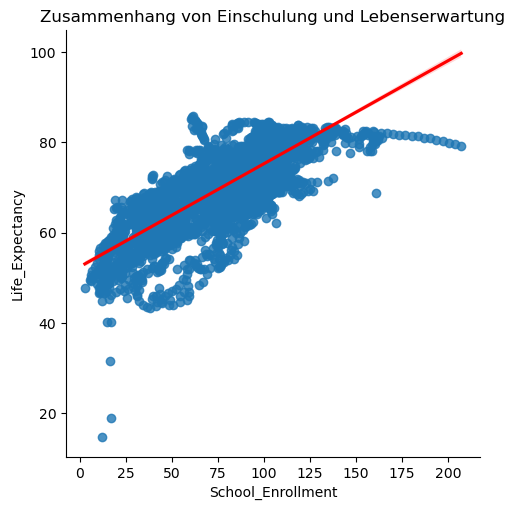

In [20]:
sns.lmplot(data=df_interpolated, x='School_Enrollment', y='Life_Expectancy', height=5, line_kws={'color': 'red'})
plt.title('Zusammenhang von Einschulung und Lebenserwartung')
plt.savefig(
    'school_vs_life.png', 
    dpi=300, # Auflösung in "dots per inch" 
    bbox_inches='tight' # Schneidet überschüssigen weißen Rand ab
)
plt.show()

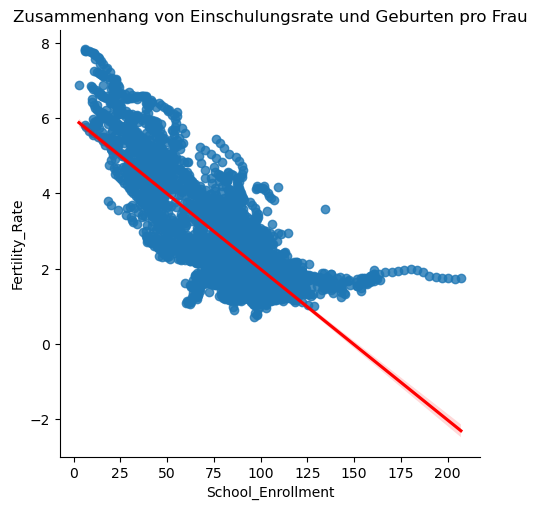

In [21]:
sns.lmplot(data=df_interpolated, x='School_Enrollment', y='Fertility_Rate', height=5, line_kws={'color': 'red'})
plt.title('Zusammenhang von Einschulungsrate und Geburten pro Frau')
plt.savefig(
    'school_vs_fertility.png', 
    dpi=300, # Auflösung in "dots per inch" 
    bbox_inches='tight' # Schneidet überschüssigen weißen Rand ab
)
plt.show()

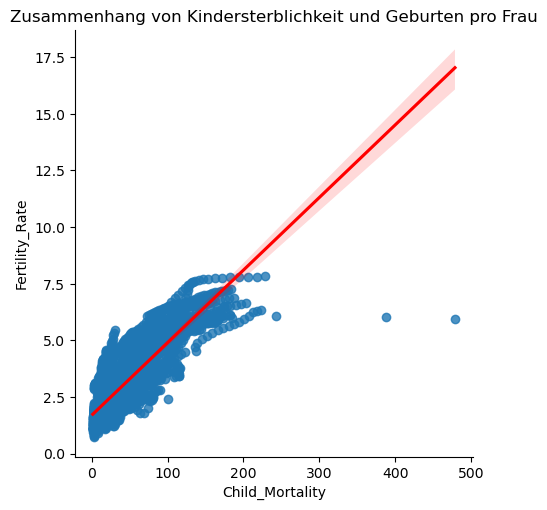

In [22]:
sns.lmplot(data=df_interpolated, x='Child_Mortality', y='Fertility_Rate', height=5, line_kws={'color': 'red'})
plt.title('Zusammenhang von Kindersterblichkeit und Geburten pro Frau')
plt.savefig(
    'mortality_vs_fertility.png', 
    dpi=300, # Auflösung in "dots per inch" 
    bbox_inches='tight' # Schneidet überschüssigen weißen Rand ab
)
plt.show()

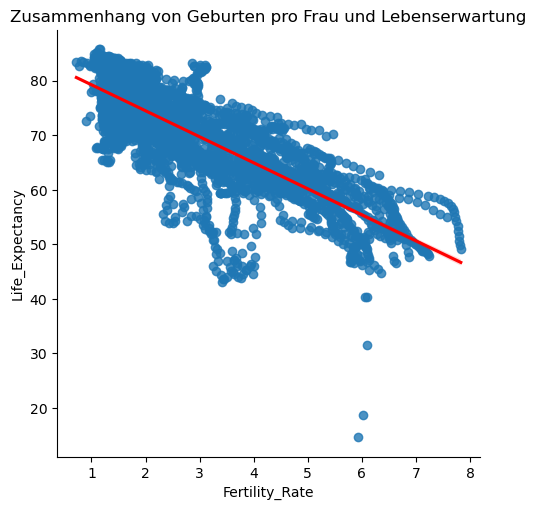

In [23]:
sns.lmplot(data=df_interpolated, x='Fertility_Rate', y='Life_Expectancy', height=5, line_kws={'color': 'red'})
plt.title('Zusammenhang von Geburten pro Frau und Lebenserwartung')
plt.savefig(
    'fertility_vs_life.png', 
    dpi=300, # Auflösung in "dots per inch" 
    bbox_inches='tight' # Schneidet überschüssigen weißen Rand ab
)
plt.show()

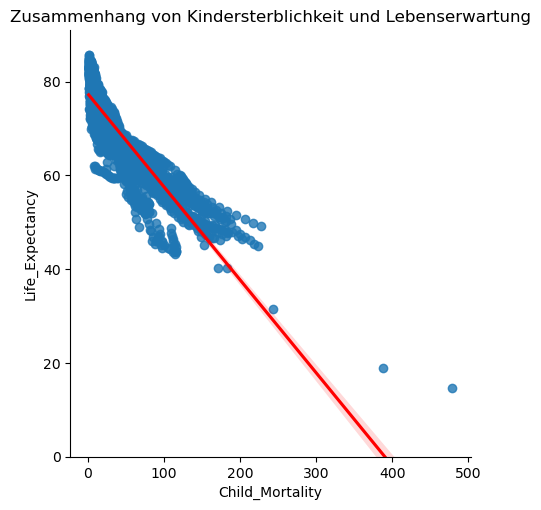

In [24]:
g = sns.lmplot(
    data=df_interpolated, 
    x='Child_Mortality', 
    y='Life_Expectancy', 
    height=5,
    line_kws={'color': 'red'}
)

# Setze die untere Grenze der Y-Achse auf 0
g.set(ylim=(0, None)) 

plt.title('Zusammenhang von Kindersterblichkeit und Lebenserwartung')
plt.savefig(
    'mortality_vs_life.png', 
    dpi=300, # Auflösung in "dots per inch" 
    bbox_inches='tight' # Schneidet überschüssigen weißen Rand ab
)
plt.show()